## 모바일 앱 사용자 행동 분석 프로젝트
### Goal : 사용자 리텐션 분석 및 행동 패턴 파악하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy.stats import ttest_ind

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
file_path = "mobile_app_interactions_expanded.csv"

df = pd.read_csv(file_path)

In [3]:
print("데이터 크기:", df.shape)
print("\n컬럼 정보:")
print(df.info())

print("\n컬럼별 고유값 개수:")
for col in df.columns:
    print(f"  {col}: {df[col].nunique():,}개")

print("\n결측치 확인:")
print(df.isnull().sum())

print("\n데이터 샘플 (처음 5행):")
print(df.head())

데이터 크기: (100000, 23)

컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   timestamp             99694 non-null  object
 1   user_id               99659 non-null  object
 2   session_id            99680 non-null  object
 3   ip_address            99683 non-null  object
 4   device_os             99686 non-null  object
 5   device_os_version     99626 non-null  object
 6   device_model          99646 non-null  object
 7   screen_resolution     99688 non-null  object
 8   location_country      99680 non-null  object
 9   location_city         99692 non-null  object
 10  app_language          99672 non-null  object
 11  network_type          99661 non-null  object
 12  battery_level         99710 non-null  object
 13  memory_usage_mb       99682 non-null  object
 14  event_type            99650 non-null  object
 15  event_

### 데이터 전처리

In [4]:

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp']) 

df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

if 'session_duration_sec' in df.columns:
    df['session_duration_sec'] = pd.to_numeric(df['session_duration_sec'], 
                                               errors='coerce')
    df = df.dropna(subset=['session_duration_sec'])
    duration_95 = df['session_duration_sec'].quantile(0.95)
    df = df[df['session_duration_sec'] <= duration_95]
elif 'session_duration' in df.columns:
    df['session_duration'] = pd.to_numeric(df['session_duration'], 
                                           errors='coerce')
    df = df.dropna(subset=['session_duration'])  
    duration_95 = df['session_duration'].quantile(0.95)
    df = df[df['session_duration'] <= duration_95]
    df['session_duration_sec'] = df['session_duration']
else:
    print(" 세션 지속시간 컬럼을 찾을 수 없습니다.")

# 사용자별 첫 활동일
user_first_activity = df.groupby('user_id')['timestamp'].min().reset_index()
user_first_activity.columns = ['user_id', 'first_activity_date']
df = df.merge(user_first_activity, on='user_id')

# 활동 경과일
df['days_since_first'] = (df['timestamp'] - df['first_activity_date']).dt.days

print("전처리 작업 이후 데이터 크기:", df.shape)


전처리 작업 이후 데이터 크기: (92998, 28)


### Basic statistics Information

In [5]:
# 전체 사용자 수
total_users = df['user_id'].nunique()
total_sessions = df['session_id'].nunique() if 'session_id' in df.columns else df.shape[0]
print(f" 전체 사용자 수: {total_users:,}명")
print(f" 전체 세션/이벤트 수: {total_sessions:,}개")

# 기간별 통계
analysis_start = df['timestamp'].min()
analysis_end = df['timestamp'].max()
analysis_period = (analysis_end - analysis_start).days
print(f" 분석 기간: {analysis_start.date()} ~ {analysis_end.date()} ({analysis_period}일)")

# 이벤트 타입별 분포
print("\n 이벤트 타입별 분포:")
event_counts = df['event_type'].value_counts()
for event, count in event_counts.head(10).items(): 
    percentage = (count / len(df)) * 100
    print(f"  {event}: {count:,}회 ({percentage:.1f}%)")

print("\n 디바이스 OS별 분포:")
if 'device_os' in df.columns:
    device_counts = df['device_os'].value_counts()
    for device, count in device_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {device}: {count:,}회 ({percentage:.1f}%)")
elif 'device_type' in df.columns:
    device_counts = df['device_type'].value_counts()
    for device, count in device_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {device}: {count:,}회 ({percentage:.1f}%)")
else:
    print("디바이스 정보를 찾을 수 없습니다.")

 전체 사용자 수: 60,471명
 전체 세션/이벤트 수: 88,107개
 분석 기간: 2024-01-13 ~ 2125-01-07 (36884일)

 이벤트 타입별 분포:
  share: 9,386회 (10.1%)
  click: 9,356회 (10.1%)
  swipe: 9,220회 (9.9%)
  scroll: 9,217회 (9.9%)
  zoom: 9,184회 (9.9%)
  long_press: 9,176회 (9.9%)
  view: 9,160회 (9.8%)
  double_tap: 9,154회 (9.8%)
  like: 9,124회 (9.8%)
  pinch: 9,096회 (9.8%)

 디바이스 OS별 분포:
  Android: 52,609회 (56.6%)
  iOS: 39,479회 (42.5%)
  iuS: 4회 (0.0%)
  iO6: 4회 (0.0%)
  Andromd: 4회 (0.0%)
  Kndroid: 3회 (0.0%)
  ifS: 3회 (0.0%)
  iOK: 3회 (0.0%)
  iDS: 3회 (0.0%)
  Androhd: 3회 (0.0%)
  iOE: 3회 (0.0%)
  iTS: 3회 (0.0%)
  iUS: 3회 (0.0%)
  iOL: 3회 (0.0%)
  AOS: 3회 (0.0%)
  iXS: 2회 (0.0%)
  iOV: 2회 (0.0%)
  rOS: 2회 (0.0%)
  Androig: 2회 (0.0%)
  i6S: 2회 (0.0%)
  gOS: 2회 (0.0%)
  jOS: 2회 (0.0%)
  iOw: 2회 (0.0%)
  tOS: 2회 (0.0%)
  AndAoid: 2회 (0.0%)
  Andrmid: 2회 (0.0%)
  igS: 2회 (0.0%)
  AnSroid: 2회 (0.0%)
  AFdroid: 2회 (0.0%)
  And5oid: 2회 (0.0%)
  6OS: 2회 (0.0%)
  iAS: 2회 (0.0%)
  Andrdid: 2회 (0.0%)
  JOS: 2회 (0.0%)
  iO5: 2회 (0.0%

### 사용자별 행동 특성 분석

In [6]:
# 세션 지속시간 컬럼 확인
duration_col = None
if 'session_duration_sec' in df.columns:
    duration_col = 'session_duration_sec'
elif 'session_duration' in df.columns:
    duration_col = 'session_duration'
elif 'duration' in df.columns:
    duration_col = 'duration'

# 사용자별 기본 통계 
session_col = 'session_id' if 'session_id' in df.columns else 'timestamp'

agg_dict = {
    session_col: 'nunique' if session_col == 'session_id' else 'count',          
    'timestamp': ['min', 'max'],        
    'event_type': 'count',        
    'days_since_first': 'max'      
}

if duration_col:
    agg_dict[duration_col] = ['mean', 'sum']

user_stats = df.groupby('user_id').agg(agg_dict).round(2)

if duration_col:
    new_columns = ['total_sessions', 'first_activity', 'last_activity', 
                   'avg_duration', 'total_duration', 'total_events', 'active_days']
else:
    new_columns = ['total_sessions', 'first_activity', 'last_activity', 'total_events', 'active_days']

user_stats.columns = new_columns
user_stats = user_stats.reset_index()

user_stats['active_days'] = user_stats['active_days'] + 1 

print("사용자별 통계 요약:")
print(user_stats[['total_sessions', 'total_events', 'active_days']].describe())

# 사용자 활동 수준별 분류
session_q1 = user_stats['total_sessions'].quantile(0.25)
session_q3 = user_stats['total_sessions'].quantile(0.75)

user_stats['user_type'] = 'Medium'
user_stats.loc[user_stats['total_sessions'] <= session_q1, 'user_type'] = 'Light'
user_stats.loc[user_stats['total_sessions'] >= session_q3, 'user_type'] = 'Heavy'

print(f"\n 사용자 활동 수준별 분류:")
print(f"  Light User (세션 {session_q1:.0f}개 이하): {(user_stats['user_type']=='Light').sum()}명")
print(f"  Medium User: {(user_stats['user_type']=='Medium').sum()}명")
print(f"  Heavy User (세션 {session_q3:.0f}개 이상): {(user_stats['user_type']=='Heavy').sum()}명")


사용자별 통계 요약:
       total_sessions  total_events   active_days
count    60471.000000  60471.000000  60471.000000
mean         1.533082   1715.116765   2641.983595
std          0.783233    869.867840   1822.281462
min          0.000000     10.000000     11.000000
25%          1.000000   1051.000000   1300.000000
50%          1.000000   1719.000000   2396.000000
75%          2.000000   2375.000000   3385.000000
max          8.000000   3422.000000  14310.000000

 사용자 활동 수준별 분류:
  Light User (세션 1개 이하): 36743명
  Medium User: 0명
  Heavy User (세션 2개 이상): 23728명


### 리텐션 분석

사용자 유지율을 측정하고 분석함. 
방문시점, 사용자 특정 행동 등등

In [7]:
# 각 사용자의 D1, D7, D30 리텐션 계산
retention_data = []

for user_id in user_stats['user_id']:
    user_activities = df[df['user_id'] == user_id]['days_since_first'].unique()
    
    # 각 날짜별 활동 여부
    day_1_active = 1 in user_activities
    day_7_active = any(day >= 7 for day in user_activities)
    day_30_active = any(day >= 30 for day in user_activities)
    
    retention_data.append({
        'user_id': user_id,
        'day_1_retained': day_1_active,
        'day_7_retained': day_7_active,
        'day_30_retained': day_30_active
    })

retention_df = pd.DataFrame(retention_data)

total_users_ret = len(retention_df)
day_1_retention = retention_df['day_1_retained'].sum() / total_users_ret * 100
day_7_retention = retention_df['day_7_retained'].sum() / total_users_ret * 100
day_30_retention = retention_df['day_30_retained'].sum() / total_users_ret * 100

print("전체 리텐션 결과:")
print(f"  D1 리텐션: {day_1_retention:.1f}% ({retention_df['day_1_retained'].sum()}명)")
print(f"  D7 리텐션: {day_7_retention:.1f}% ({retention_df['day_7_retained'].sum()}명)")
print(f"  D30 리텐션: {day_30_retention:.1f}% ({retention_df['day_30_retained'].sum()}명)")


전체 리텐션 결과:
  D1 리텐션: 3.0% (1834명)
  D7 리텐션: 26.4% (15947명)
  D30 리텐션: 0.0% (3명)


### Data visualization 

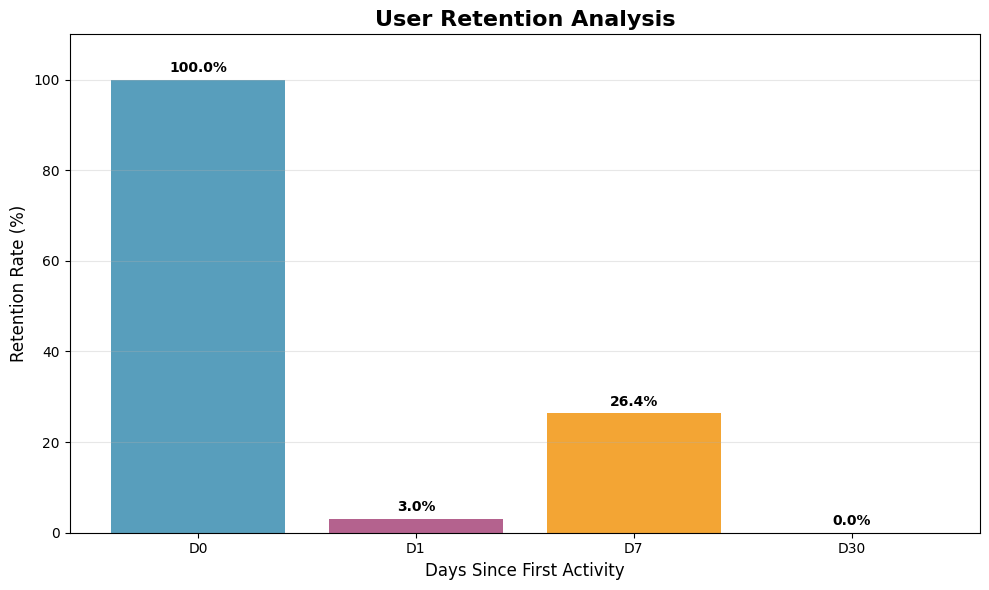

In [8]:
# 시각화 1: 리텐션 막대 그래프
plt.figure(figsize=(10, 6))
retention_rates = [100, day_1_retention, day_7_retention, day_30_retention]
days = ['D0', 'D1', 'D7', 'D30']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

bars = plt.bar(days, retention_rates, color=colors, alpha=0.8)
plt.title('User Retention Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Retention Rate (%)', fontsize=12)
plt.xlabel('Days Since First Activity', fontsize=12)

for bar, rate in zip(bars, retention_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 110)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

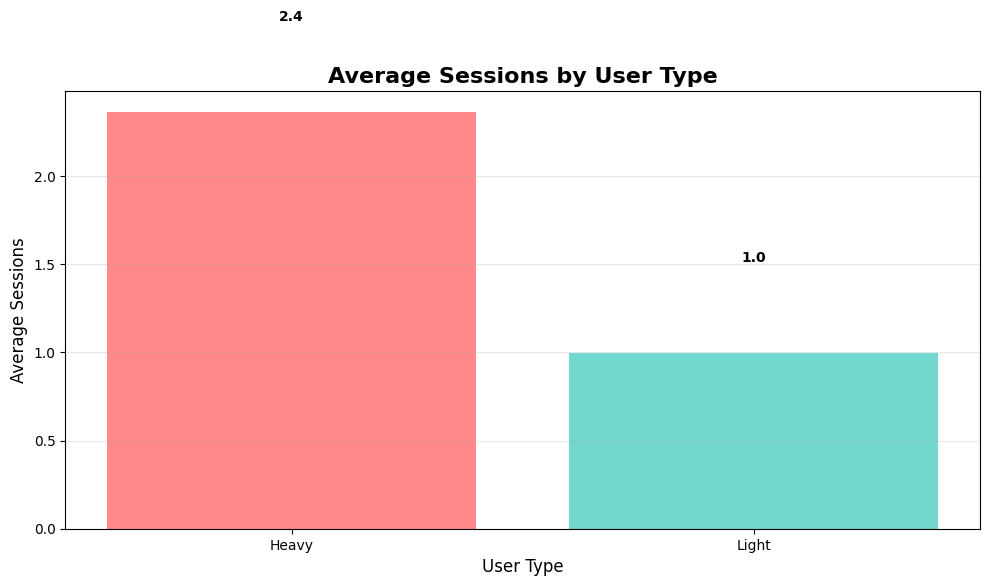

In [9]:
# 시각화 2: 사용자 타입별 평균 세션 수
plt.figure(figsize=(10, 6))
user_type_sessions = user_stats.groupby('user_type')['total_sessions'].mean().sort_values(ascending=False)

bars = plt.bar(user_type_sessions.index, user_type_sessions.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
plt.title('Average Sessions by User Type', fontsize=16, fontweight='bold')
plt.ylabel('Average Sessions', fontsize=12)
plt.xlabel('User Type', fontsize=12)

for bar, value in zip(bars, user_type_sessions.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

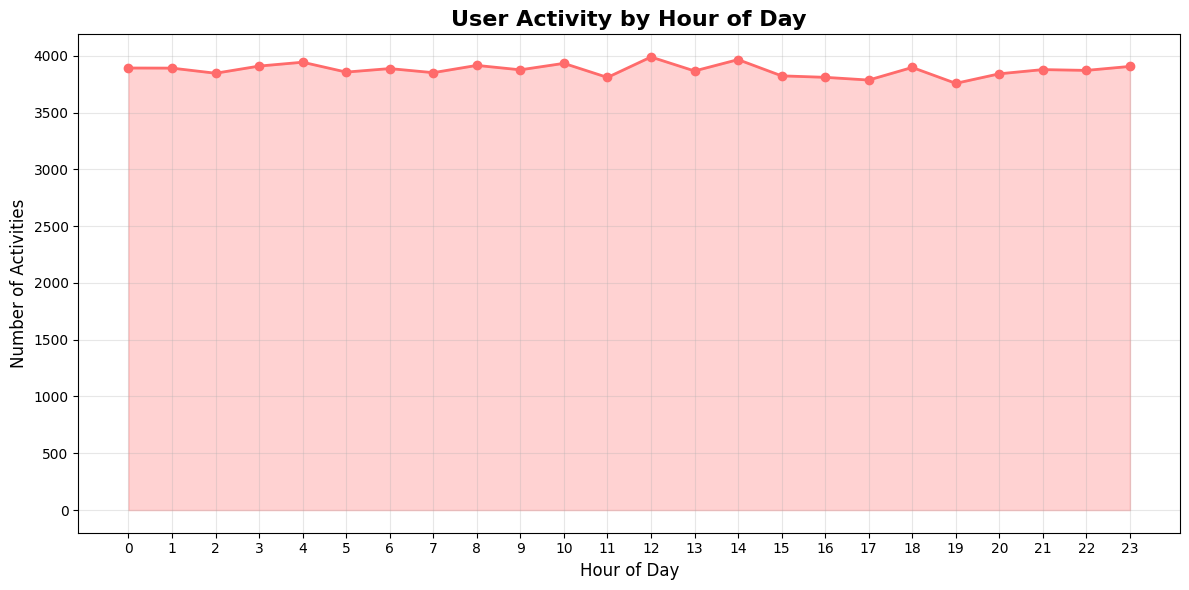

In [10]:
# 시각화 3: 시간대별 활동 패턴
plt.figure(figsize=(12, 6))
hourly_activity = df.groupby('hour').size()
plt.plot(hourly_activity.index, hourly_activity.values, 
        marker='o', linewidth=2, color='#FF6B6B')
plt.fill_between(hourly_activity.index, hourly_activity.values, alpha=0.3, color='#FF6B6B')
plt.title('User Activity by Hour of Day', 
           fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Activities', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

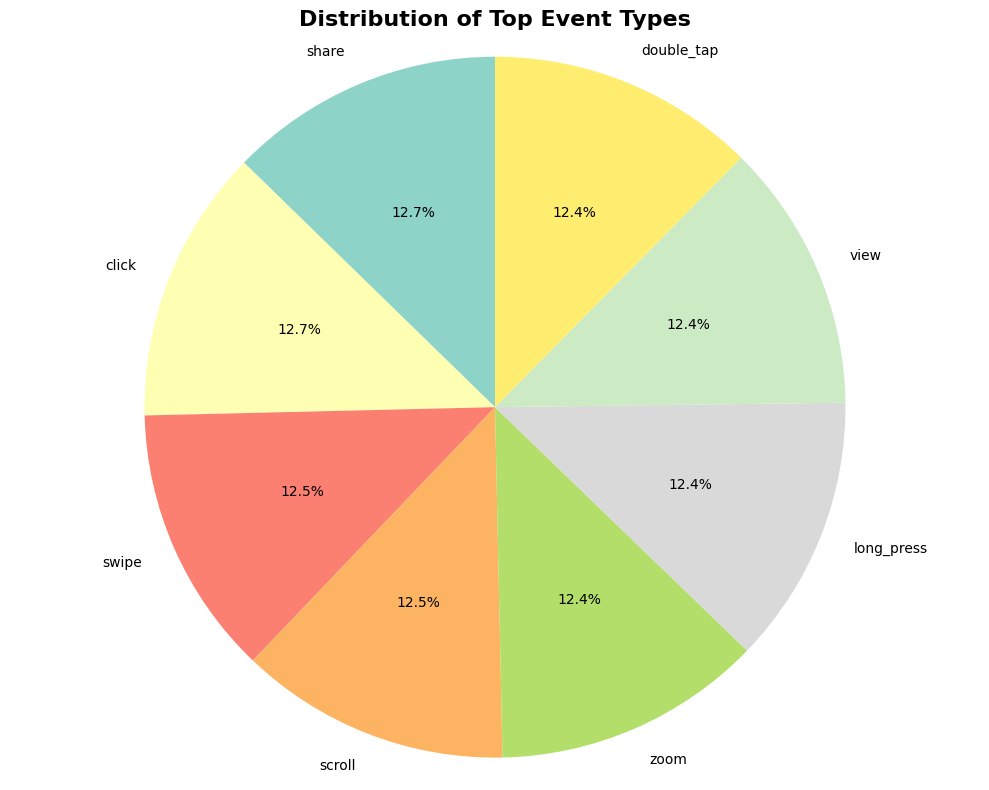

In [11]:
# 시각화 4: 이벤트 타입별 분포 (파이 차트) - 상위 8개
plt.figure(figsize=(10, 8))
top_events = df['event_type'].value_counts().head(8)  # 상위 8개만
colors = plt.cm.Set3(np.linspace(0, 1, len(top_events)))

plt.pie(top_events.values, labels=top_events.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Distribution of Top Event Types', 
           fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

### 코호트 분석 (주별 가입 사용자 그룹별 리텐션)

 주별 코호트 리텐션 테이블 (처음 5주):
period_number          0      1      2      3      4     520   1564  3131
cohort_week                                                              
2024-01-08/2024-01-14   1.0    NaN    NaN    NaN    NaN   NaN   NaN   NaN
2024-12-09/2024-12-15   1.0  1.000    NaN    NaN    NaN   NaN   NaN   NaN
2024-12-16/2024-12-22   1.0  0.198  0.193  0.199  0.078   NaN   NaN   0.0
2024-12-23/2024-12-29   1.0  0.194  0.197  0.078    NaN   NaN   NaN   NaN
2024-12-30/2025-01-05   1.0  0.196  0.075    NaN    NaN   NaN   0.0   NaN


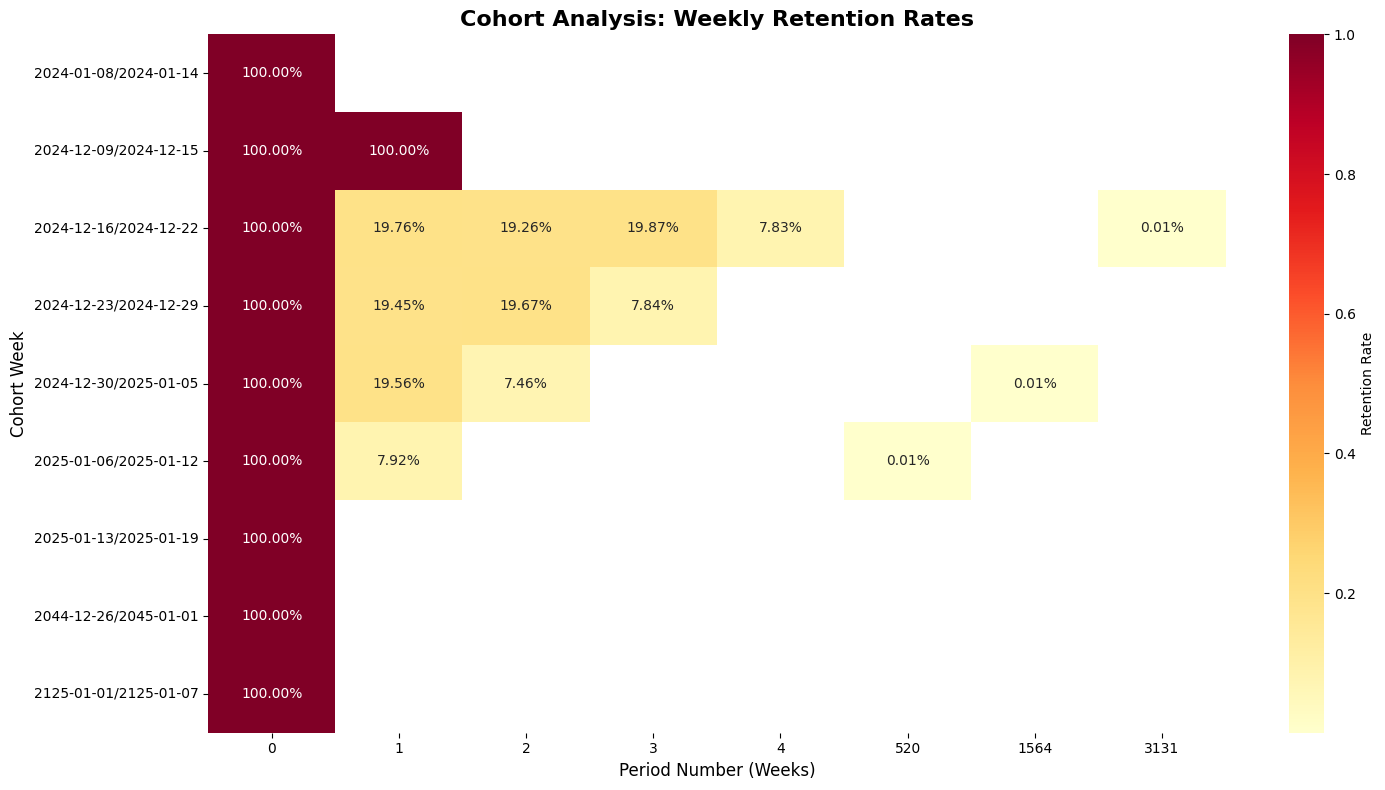

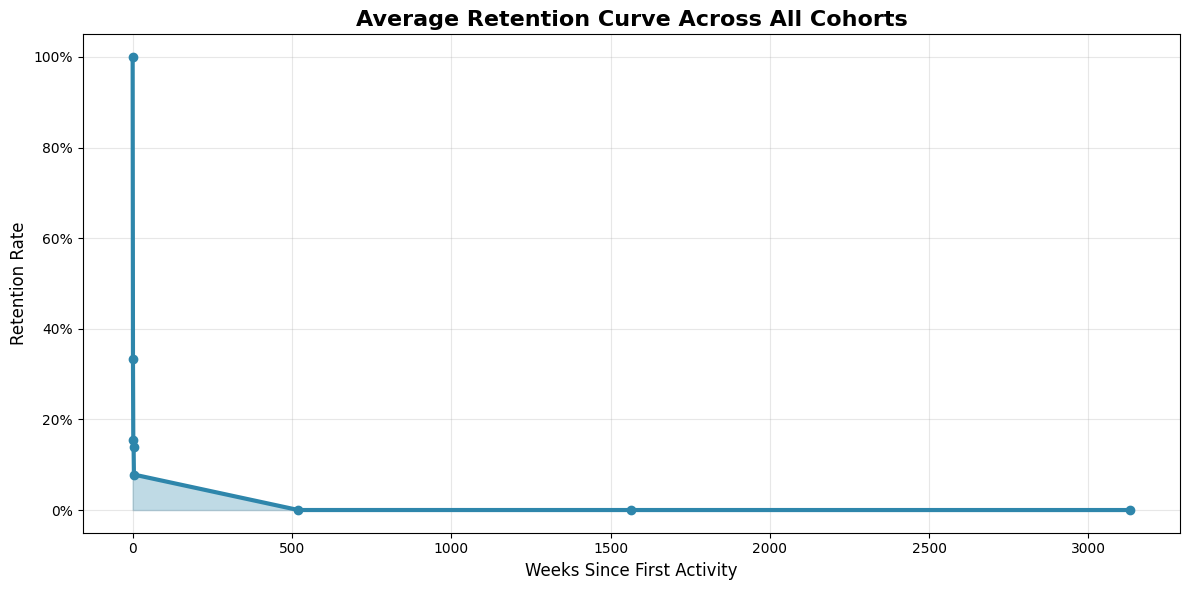

 코호트 분석 완료!
   - 평균 4주차 리텐션: 7.8%


In [12]:
try:
    df_clean = df.dropna(subset=['timestamp', 'first_activity_date']).copy()
    
    # 주별 코호트 생성
    df_clean['cohort_week'] = df_clean['first_activity_date'].dt.to_period('W')
    df_clean['activity_week'] = df_clean['timestamp'].dt.to_period('W')
    
    # period_number 계산 (NaT 에러 방지)
    period_diffs = []
    for idx, row in df_clean.iterrows():
        try:
            if pd.notna(row['activity_week']) and pd.notna(row['cohort_week']):
                diff = (row['activity_week'] - row['cohort_week']).n
                period_diffs.append(diff)
            else:
                period_diffs.append(np.nan)
        except:
            period_diffs.append(np.nan)
    
    df_clean['period_number'] = period_diffs
    df_clean = df_clean.dropna(subset=['period_number'])
    
    cohort_data = df_clean.groupby(['cohort_week', 'period_number'])['user_id'].nunique().reset_index()
    cohort_sizes = df_clean.groupby('cohort_week')['user_id'].nunique()
    
    cohort_table = cohort_data.pivot(index='cohort_week', columns='period_number', values='user_id')
    
    # 리텐션 비율 계산
    cohort_sizes_df = pd.DataFrame(cohort_sizes).rename(columns={'user_id': 'cohort_size'})
    cohort_table = cohort_table.divide(cohort_sizes_df['cohort_size'], axis=0)
    
    print(" 주별 코호트 리텐션 테이블 (처음 5주):")
    display_cols = min(8, cohort_table.shape[1])
    display_rows = min(5, cohort_table.shape[0])
    print(cohort_table.iloc[:display_rows, :display_cols].round(3))
    
    # 코호트 히트맵 시각화
    if len(cohort_table) > 1 and cohort_table.shape[1] > 1:
        plt.figure(figsize=(15, 8))
        display_cols = min(12, cohort_table.shape[1])
        sns.heatmap(cohort_table.iloc[:, :display_cols], annot=True, fmt='.2%', cmap='YlOrRd', 
                    cbar_kws={'label': 'Retention Rate'})
        plt.title('Cohort Analysis: Weekly Retention Rates', fontsize=16, fontweight='bold')
        plt.xlabel('Period Number (Weeks)', fontsize=12)
        plt.ylabel('Cohort Week', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # 평균 리텐션 곡선
        avg_retention = cohort_table.mean()
        plt.figure(figsize=(12, 6))
        display_periods = min(12, len(avg_retention))
        plt.plot(avg_retention.index[:display_periods], avg_retention.values[:display_periods], 
                 marker='o', linewidth=3, color='#2E86AB')
        plt.fill_between(avg_retention.index[:display_periods], avg_retention.values[:display_periods], 
                         alpha=0.3, color='#2E86AB')
        plt.title('Average Retention Curve Across All Cohorts', fontsize=16, fontweight='bold')
        plt.xlabel('Weeks Since First Activity', fontsize=12)
        plt.ylabel('Retention Rate', fontsize=12)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f" 코호트 분석 완료!")
        if len(avg_retention) > 4:
            print(f"   - 평균 4주차 리텐션: {avg_retention.iloc[4]:.1%}")
        if len(avg_retention) > 8:
            print(f"   - 평균 8주차 리텐션: {avg_retention.iloc[8]:.1%}")
    else:
        print(" 충분한 데이터가 없음음.")

except Exception as e:
    print(f" 코호트 분석 중 오류: {str(e)}")
    print("코호트 분석 스킵킵.")

### 퍼널 분석 (사용자 행동 단계별 이탈)

사용 가능한 이벤트 타입: ['double_tap', 'pinch', 'zoom', 'long_press', 'view', 'share', 'swipe', 'like', 'scroll', 'click']
퍼널 분석에 사용할 이벤트: ['click', 'view']
 퍼널 분석 결과:
           Step  Users  Conversion_Rate
0     All_Users  60471            100.0
1  Step_1_click   8933             14.8
2   Step_2_view   8767             14.5


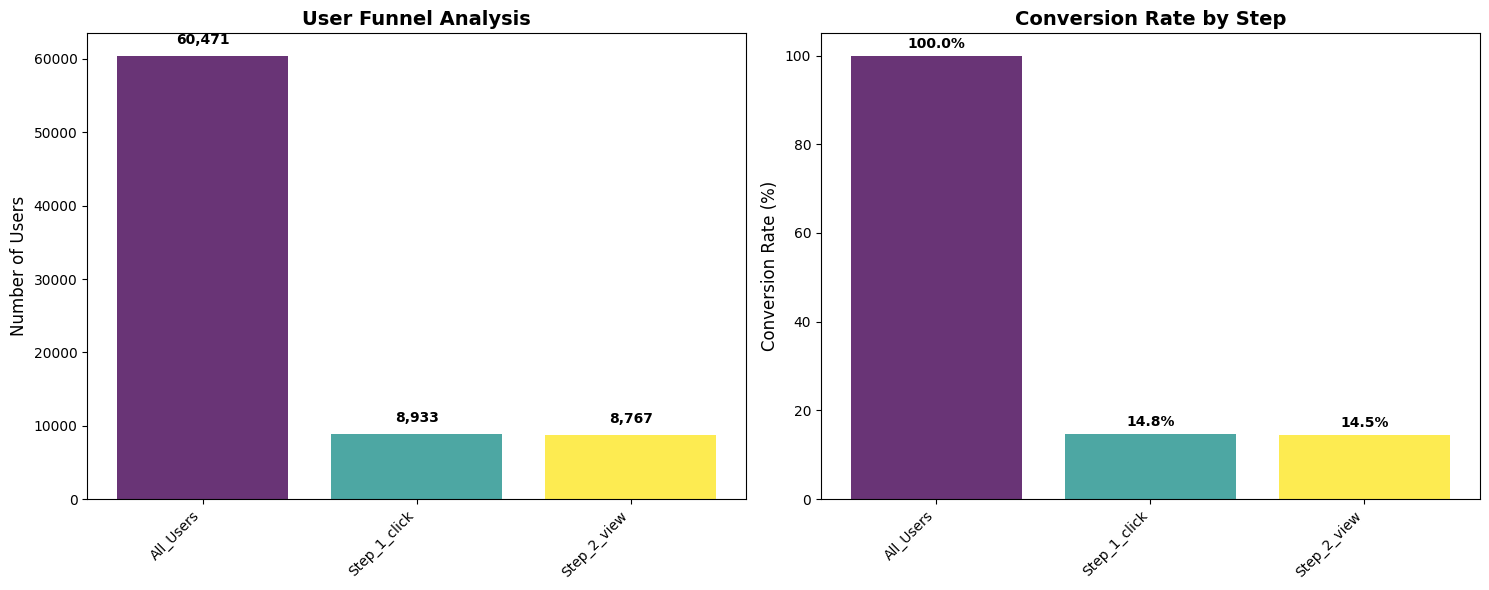

In [13]:
# 실제 존재하는 이벤트 타입 확인
available_events = df['event_type'].unique()
print(f"사용 가능한 이벤트 타입: {list(available_events[:10])}")  # 처음 10개만 표시

# 주요 이벤트들을 찾아서 퍼널 구성
funnel_events = []
for event in ['login', 'view_content', 'purchase', 'signup', 'click', 'view', 'start']:
    if any(event.lower() in str(e).lower() for e in available_events):
        matching_events = [e for e in available_events if event.lower() in str(e).lower()]
        funnel_events.extend(matching_events[:1])  # 첫 번째 매칭 이벤트만 선택

# 상위 4개 이벤트로 퍼널 구성
if not funnel_events:
    funnel_events = df['event_type'].value_counts().head(4).index.tolist()

print(f"퍼널 분석에 사용할 이벤트: {funnel_events}")

# 각 단계별 사용자 수 계산
funnel_data = {}
funnel_data['All_Users'] = df['user_id'].nunique()

for i, event in enumerate(funnel_events):
    event_users = df[df['event_type'] == event]['user_id'].nunique()
    funnel_data[f'Step_{i+1}_{event}'] = event_users

# 퍼널 데이터프레임 생성
funnel_df = pd.DataFrame(list(funnel_data.items()), columns=['Step', 'Users'])
funnel_df['Conversion_Rate'] = funnel_df['Users'] / funnel_df['Users'].iloc[0] * 100

print(" 퍼널 분석 결과:")
print(funnel_df.round(1))

# 퍼널 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 전체 퍼널
colors = plt.cm.viridis(np.linspace(0, 1, len(funnel_df)))
bars1 = ax1.bar(range(len(funnel_df)), funnel_df['Users'], color=colors, alpha=0.8)
ax1.set_title('User Funnel Analysis', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Users', fontsize=12)
ax1.set_xticks(range(len(funnel_df)))
ax1.set_xticklabels(funnel_df['Step'], rotation=45, ha='right')

for bar, users in zip(bars1, funnel_df['Users']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(funnel_df['Users'])*0.02, 
             f'{users:,}', ha='center', va='bottom', fontweight='bold')

# 전환율 그래프
bars2 = ax2.bar(range(len(funnel_df)), funnel_df['Conversion_Rate'], color=colors, alpha=0.8)
ax2.set_title('Conversion Rate by Step', fontsize=14, fontweight='bold')
ax2.set_ylabel('Conversion Rate (%)', fontsize=12)
ax2.set_xticks(range(len(funnel_df)))
ax2.set_xticklabels(funnel_df['Step'], rotation=45, ha='right')

for bar, rate in zip(bars2, funnel_df['Conversion_Rate']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### A/B 테스트 분석 (푸시 알림 효과)


In [14]:
# push_enabled 컬럼이 있는지 확인
if 'push_enabled' in df.columns:
    # A/B 테스트 그룹 설정
    push_users = df[df['push_enabled'] == True]['user_id'].unique()
    no_push_users = df[df['push_enabled'] == False]['user_id'].unique()
    
    group_a = user_stats[user_stats['user_id'].isin(push_users)]
    group_b = user_stats[user_stats['user_id'].isin(no_push_users)]
    
    if len(group_a) > 0 and len(group_b) > 0:
        group_a['test_group'] = 'A (Push ON)'
        group_b['test_group'] = 'B (Push OFF)'
        ab_test_data = pd.concat([group_a, group_b])
        
        print(f" A/B 테스트 그룹 크기:")
        print(f"   - A그룹 (푸시 ON): {len(group_a)}명")
        print(f"   - B그룹 (푸시 OFF): {len(group_b)}명")
        
        # 주요 메트릭 비교
        metrics_comparison = ab_test_data.groupby('test_group').agg({
            'total_sessions': ['mean', 'std'],
            'total_events': ['mean', 'std'],
            'active_days': ['mean', 'std']
        }).round(2)
        
        print("\n 그룹별 주요 메트릭 비교:")
        print(metrics_comparison)
        
        # 통계적 유의성 검정
        sessions_a = group_a['total_sessions']
        sessions_b = group_b['total_sessions']
        
        if len(sessions_a) > 1 and len(sessions_b) > 1:
            t_stat_sessions, p_val_sessions = ttest_ind(sessions_a, sessions_b)
            
            print(f"\n 통계적 검정 결과:")
            print(f"   세션 수 차이:")
            print(f"     - A그룹 평균: {sessions_a.mean():.1f}회")
            print(f"     - B그룹 평균: {sessions_b.mean():.1f}회")
            print(f"     - p-value: {p_val_sessions:.4f} ({'통계적으로 유의함' if p_val_sessions < 0.05 else '통계적으로 유의하지 않음'})")
        
    else:
        print(" A/B 테스트 그룹 데이터가 충분하지 않습니다.")
else:
    print(" push_enabled 컬럼을 찾을 수 없어 A/B 테스트를 건너뜁니다.")
    
    np.random.seed(42)
    user_stats['test_group'] = np.random.choice(['Group A', 'Group B'], size=len(user_stats))
    
    print(" 랜덤 그룹 비교 (데모):")
    group_comparison = user_stats.groupby('test_group')[['total_sessions', 'total_events', 'active_days']].mean()
    print(group_comparison.round(2))


 A/B 테스트 그룹 데이터가 충분하지 않습니다.


### 시계열 분석 (DAU, WAU, MAU, 요일별 패턴)

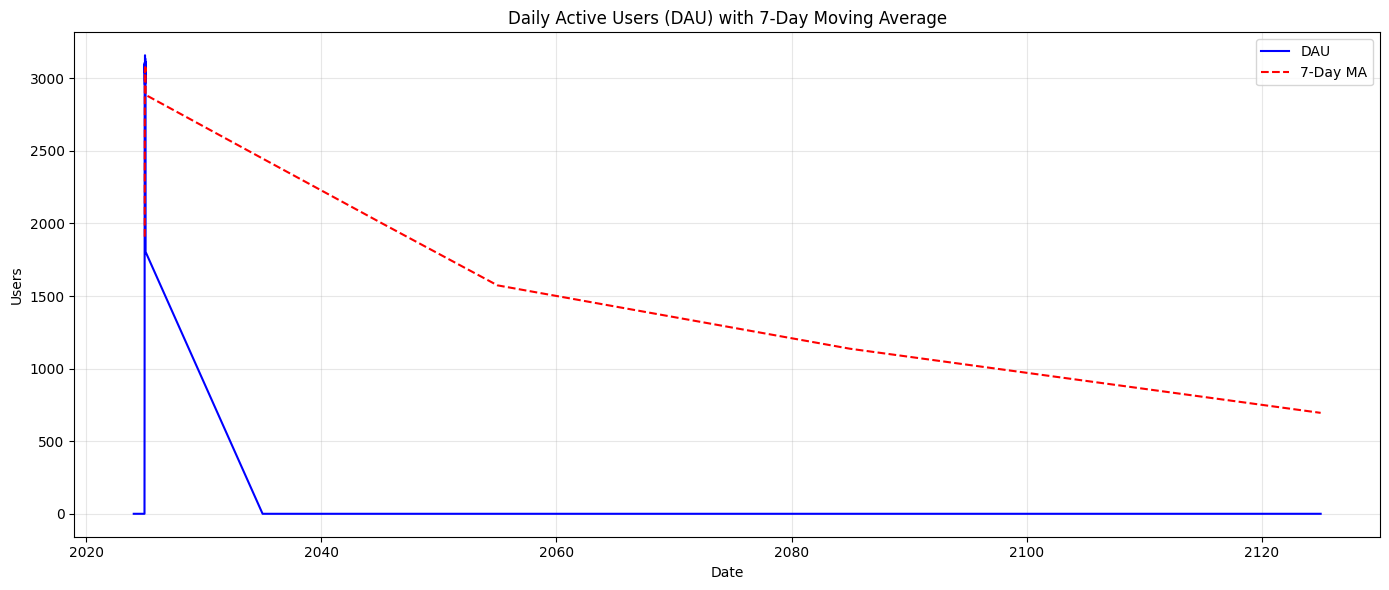

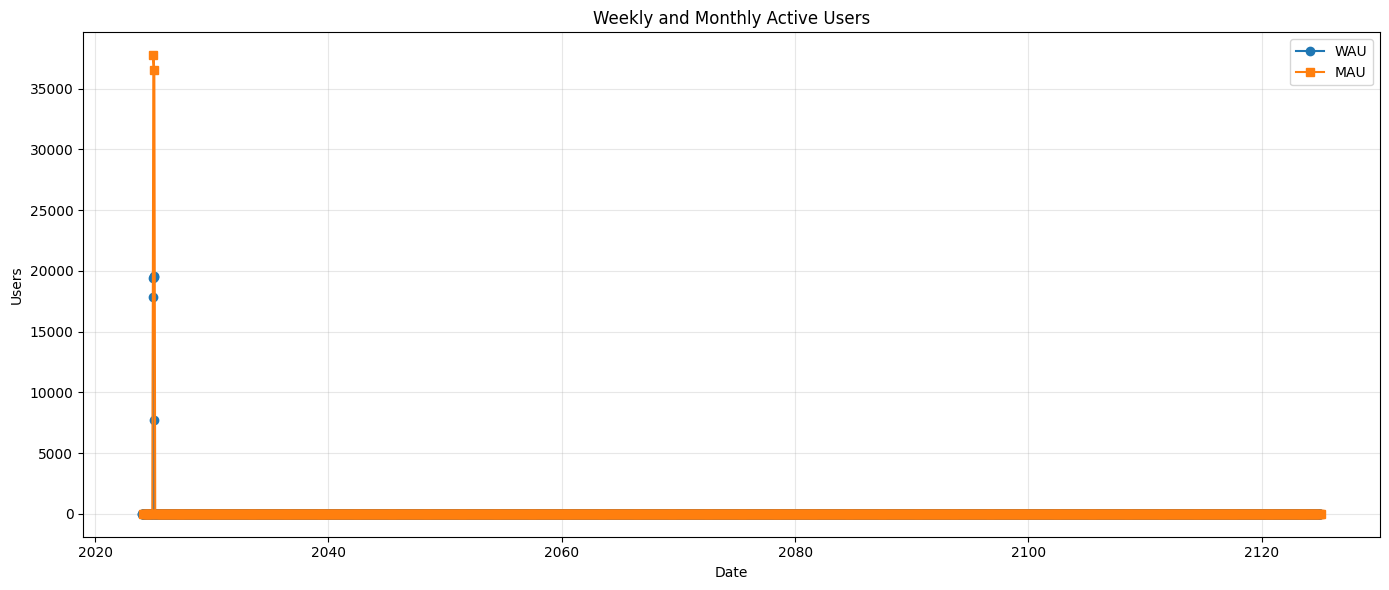

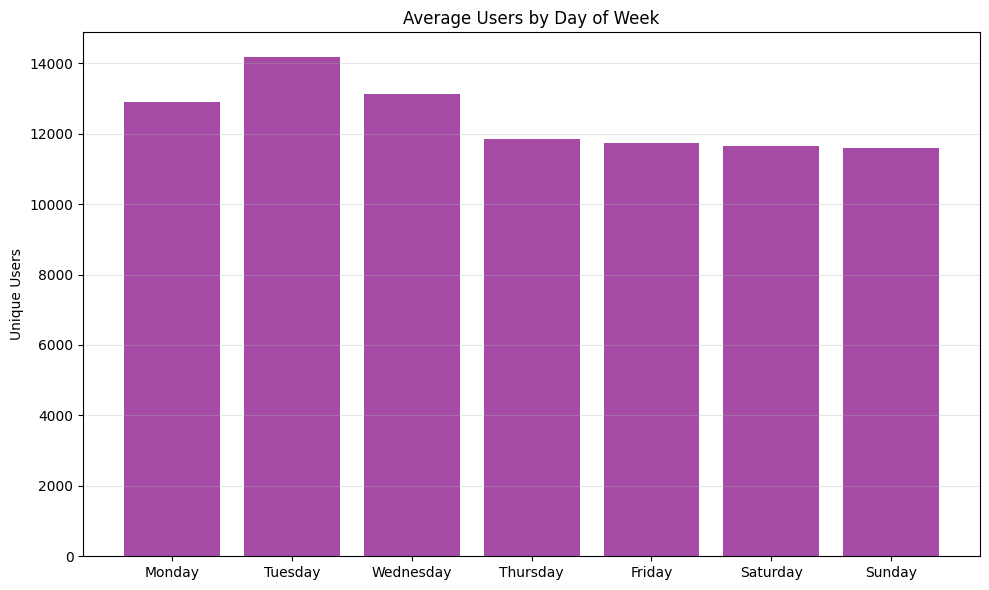

In [15]:
# DAU, WAU, MAU 계산
dau = df.groupby('date')['user_id'].nunique()
wau = df.groupby(pd.Grouper(key='timestamp', freq='W'))['user_id'].nunique()
mau = df.groupby(pd.Grouper(key='timestamp', freq='M'))['user_id'].nunique()

# 7일 이동평균
dau_ma7 = dau.rolling(7).mean()

# DAU 시각화
plt.figure(figsize=(14,6))
plt.plot(dau.index, dau.values, label='DAU', color='blue')
plt.plot(dau_ma7.index, dau_ma7.values, label='7-Day MA', color='red', linestyle='--')
plt.title('Daily Active Users (DAU) with 7-Day Moving Average')
plt.xlabel('Date'); plt.ylabel('Users')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# WAU & MAU 시각화
plt.figure(figsize=(14,6))
plt.plot(wau.index, wau.values, label='WAU', marker='o')
plt.plot(mau.index, mau.values, label='MAU', marker='s')
plt.title('Weekly and Monthly Active Users')
plt.xlabel('Date'); plt.ylabel('Users')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# 요일별 평균 활동
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_activity = df.groupby('day_of_week')['user_id'].nunique().reindex(dow_order)

plt.figure(figsize=(10,6))
plt.bar(dow_activity.index, dow_activity.values, color='purple', alpha=0.7)
plt.title('Average Users by Day of Week')
plt.ylabel('Unique Users')
plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

### 인사이트 정리

In [16]:
print(" 주요 발견사항:")
print(f"1. 기본 리텐션 현황:")
print(f"   - D1: {day_1_retention:.1f}% (일반적 기준: 60-70%)")
print(f"   - D7: {day_7_retention:.1f}% (일반적 기준: 25-35%)")
print(f"   - D30: {day_30_retention:.1f}% (일반적 기준: 10-15%)")

heavy_user_pct = (user_stats['user_type']=='Heavy').sum() / len(user_stats) * 100
print(f"\n2. 사용자 분포:")
print(f"   - Heavy 사용자 비율: {heavy_user_pct:.1f}%")
print(f"   - 이들이 전체 활동의 큰 부분을 차지할 가능성 높음")

if 'cohort_table' in locals() and len(cohort_table) > 4:
    print(f"\n3. 코호트 분석 결과:")
    if 'avg_retention' in locals() and len(avg_retention) > 4:
        print(f"   - 4주차 평균 리텐션: {avg_retention.iloc[4]:.1%}")
    print(f"   - 시간이 지날수록 리텐션이 안정화되는 패턴")

print(f"\n4. 퍼널 분석 결과:")
if len(funnel_df) > 1:
    final_conversion = funnel_df.iloc[-1]['Conversion_Rate']
    print(f"   - 최종 전환율: {final_conversion:.1f}%")
    print(f"   - 주요 이탈 지점에서 집중적 개선 필요")

print(f"\n 비즈니스 액션 아이템:")
print(f"1. 온보딩 최적화: 첫 주 리텐션 집중 관리")
print(f"2. 사용자 세그멘테이션: Heavy/Medium/Light 사용자별 차별화 전략")
print(f"3. 퍼널 개선: 주요 이탈 지점 UX 개선")
print(f"4. 시간대별 최적화: 피크 시간대 활용한 푸시 전략")
print(f"5. 코호트별 맞춤 전략: 시기별 차별화된 접근")
print(f"\n 총 {total_users:,}명의 사용자 데이터를 분석했습니다.")

 주요 발견사항:
1. 기본 리텐션 현황:
   - D1: 3.0% (일반적 기준: 60-70%)
   - D7: 26.4% (일반적 기준: 25-35%)
   - D30: 0.0% (일반적 기준: 10-15%)

2. 사용자 분포:
   - Heavy 사용자 비율: 39.2%
   - 이들이 전체 활동의 큰 부분을 차지할 가능성 높음

3. 코호트 분석 결과:
   - 4주차 평균 리텐션: 7.8%
   - 시간이 지날수록 리텐션이 안정화되는 패턴

4. 퍼널 분석 결과:
   - 최종 전환율: 14.5%
   - 주요 이탈 지점에서 집중적 개선 필요

 비즈니스 액션 아이템:
1. 온보딩 최적화: 첫 주 리텐션 집중 관리
2. 사용자 세그멘테이션: Heavy/Medium/Light 사용자별 차별화 전략
3. 퍼널 개선: 주요 이탈 지점 UX 개선
4. 시간대별 최적화: 피크 시간대 활용한 푸시 전략
5. 코호트별 맞춤 전략: 시기별 차별화된 접근

 총 60,471명의 사용자 데이터를 분석했습니다.
